In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
def load_preproccess_scale_transform(csv_filepath):
    dataset = pd.read_csv(csv_filepath)
    dataset.drop(
        [
            "Date",
            "SM_2",
            "SM_8",
            "SM_20",
            "SM_40",
            "ST_2",
            "ST_8",
            "ST_20",
            "ST_40",
            "solarenergy",
            "precipprob",
            "preciptype",
            "snow",
            "snowdepth",
            "windgust",
            "winddir",
            "sealevelpressure",
            "visibility",
            "solarenergy",
            "uvindex",
            "severerisk",
            "icon",
            "stations",
            "dew",
            "solarradiation",
            "Time",
            # "cloudcover",
            "feelslike",
            # "windspeed",
        ],
        inplace=True,
        axis=1,
    )
    dataset.dropna(inplace=True)

    X = dataset.iloc[:, 1:].values
    y = dataset.iloc[:, 0].values

    ct = ColumnTransformer(
        transformers=[("encoder", OneHotEncoder(), [-1])], remainder="passthrough"
    )

    X = np.array(ct.fit_transform(X))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )
    sc = StandardScaler()
    X_train[:, 9:] = sc.fit_transform(X_train[:, 9:])
    X_test[:, 9:] = sc.transform(X_test[:, 9:])

    X_train, y_train, X_test, y_test = map(
        np.asarray, [X_train, y_train, X_test, y_test]
    )
    X_train, X_test = map(lambda x: x.astype("float32"), [X_train, X_test])

    return (X_train, y_train), (X_test, y_test)

In [13]:
(X_train, y_train), (X_test, y_test) = load_preproccess_scale_transform(
    "storage_dataset/prototype_final_dataset.csv"
)

Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 420.4111 - mean_absolute_error: 17.0249 - val_loss: 33.5986 - val_mean_absolute_error: 4.3194
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 24.6340 - mean_absolute_error: 3.8389 - val_loss: 21.1392 - val_mean_absolute_error: 3.6711
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 18.7904 - mean_absolute_error: 3.4534 - val_loss: 18.1435 - val_mean_absolute_error: 3.4371
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 16.5524 - mean_absolute_error: 3.2683 - val_loss: 16.2785 - val_mean_absolute_error: 3.2548
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 15.1751 - mean_absolute_error: 3.1389 - val_loss: 15.5051 - val_mean_absolute_error: 3.1879
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 14.5290 - mean_absolute_error: 3.0826 - val_loss: 14.7207 - val_mean_absolute_error: 3.1

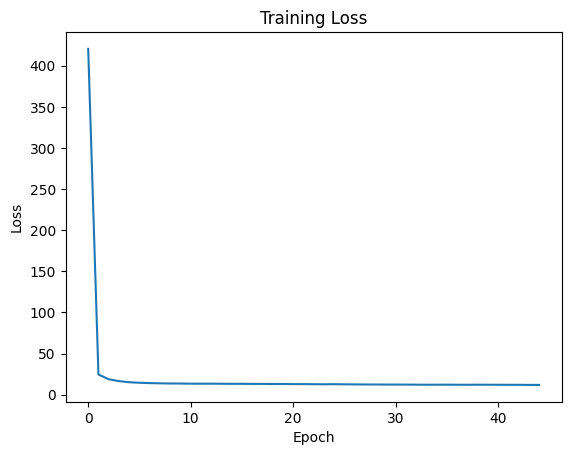

In [14]:
""" Model """
ANN_model = keras.Sequential(
    [
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(4, activation="relu"),
        keras.layers.Dense(2, activation="relu"),
        keras.layers.Dense(1),
    ]
)

ANN_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.mean_squared_error,
    metrics=keras.metrics.mean_absolute_error,
)
early_stopping = EarlyStopping(patience=5)
history = ANN_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

ANN_model.summary()

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [16]:
from sklearn.tree import DecisionTreeRegressor

# Increase maximum depth
dtr_model = DecisionTreeRegressor(
    max_depth=10, random_state=0, min_samples_split=20)

# Fine-tune hyperparameters
dtr_model.fit(
    X_train,
    y_train
)

dtr_ypred = dtr_model.predict(X_test).reshape(-1, 1)

dtr_mae = mean_absolute_error(y_test, dtr_ypred)
dtr_mse = mean_squared_error(y_test, dtr_ypred)
print("DTR MAE:", dtr_mae)
print("DTR MSE:", dtr_mse)

DTR MAE: 2.4793497949315557
DTR MSE: 11.449145084264442


In [17]:
from sklearn.svm import SVR

# Try different kernels
svr_models = [
    SVR(kernel="rbf", C=10, gamma=0.1),
    SVR(kernel="linear", C=10),
    SVR(kernel="poly", C=10, degree=3),
]

# Fine-tune hyperparameters
for model in svr_models:
    model.fit(X_train, y_train)

    svr_ypred = model.predict(X_test)

    svr_mae = mean_absolute_error(y_test, svr_ypred)
    svr_mse = mean_squared_error(y_test, svr_ypred)

    print(f"SVR {model.kernel} MAE: {svr_mae}, MSE: {svr_mse}")

SVR rbf MAE: 2.6847561788135037, MSE: 12.378814682765524
SVR linear MAE: 3.020200966574431, MSE: 14.14331691754801
SVR poly MAE: 2.7993844860451302, MSE: 13.04676907116308


In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Feature selection using L1 regularization
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)

mlr_ypred = mlr_model.predict(X_test)

mlr_mae = mean_absolute_error(y_test, mlr_ypred)
mlr_mse = mean_squared_error(y_test, mlr_ypred)
print("MLR MAE:", mlr_mae)
print("MLR MSE:", mlr_mse)

# Consider adding polynomial features

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

mlr_model_poly = LinearRegression()
mlr_model_poly.fit(X_train_poly, y_train)

mlr_poly_ypred = mlr_model_poly.predict(X_test_poly)

mlr_poly_mae = mean_absolute_error(y_test, mlr_poly_ypred)
mlr_poly_mse = mean_squared_error(y_test, mlr_poly_ypred)
print("MLR with Poly Features MAE:", mlr_poly_mae)
print("MLR with Poly Features MSE:", mlr_poly_mse)

TypeError: LinearRegression.__init__() got an unexpected keyword argument 'lasso_lars'